In [1]:
import os
os.chdir("..")
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from src.amortized_inference.dataset import UserDataset
import pickle

colors_4 = ["#DFDFDF", "#93C354", "#0077BB", "#EE7733"]
colors_2 = ["#0077BB", "#EE7733"]

In [2]:
class Study3UserDataset(UserDataset):
    def __init__(self):
        self.name = f"user_data"
        self.fpath = "./data/user_data_s3.pkl"
        self._get_dataset()

    def _get_dataset(self):
        if os.path.exists(self.fpath):
            with open(self.fpath, "rb") as f:
                self.dataset = pickle.load(f)
                self.user_list=self.dataset["user_list"]
        else:
            user_data_3a_path = "./data/study_3a"
            user_data_3a_list = os.listdir(user_data_3a_path)
            user_data_3a_list.sort()
            user_data_3a_list = [os.path.join(user_data_3a_path, user) for user in user_data_3a_list if user != ".DS_Store"]
            
            user_data_3b_path = "./data/study_3b"
            user_data_3b_list = os.listdir(user_data_3b_path)
            user_data_3b_list.sort()
            user_data_3b_list = [os.path.join(user_data_3b_path, user) for user in user_data_3b_list if user != ".DS_Store"]

            user_data_list = user_data_3a_list + user_data_3b_list
            print(f"[ Study3A ] No. of users: {len(user_data_3a_list)}")
            print(f"[ Study3B ] No. of users: {len(user_data_3b_list)}")

            df = pd.DataFrame()
            for user_i, user_path in enumerate(user_data_list):
                file_list = os.listdir(user_path)
                file_list.sort()
                file_list = [file for file in file_list if file != ".DS_Store"]

                for sess_i, file_name in enumerate(file_list):
                    user_data = pd.read_csv(os.path.join(user_path, file_name))
                    user_data["user_id"] = user_i + 1
                    user_data["session_idx"] = sess_i + 1
                    df = pd.concat([df, user_data], ignore_index=True)

            # make the user_id, session_idx start as the first two columns
            cols = df.columns.tolist()
            cols = cols[-2:] + cols[:-2]
            df = df[cols]

            self.user_list = df["user_id"].unique()

            self.dataset = dict(
                df=df,
                user_list=self.user_list,
            )
            with open(self.fpath, "wb") as f:
                pickle.dump(self.dataset, f)
    
    def get_trial_data(
        self,
        normalize=False,
        user_list=None,
        n_trial_per_user=-1,
        small_target=-1,
        dense_grid=1,
        method=4,
    ):
        if user_list is None:
            user_list = self.dataset["df"]["user_id"].unique()
        n_block = self.dataset["df"]["block_idx"].max()

        target_pos_arr = list()
        summary_arr = list()
        trajectory_arr = list()

        assert method in [0, 1, 3, 4] # 1: nearest-neighbor, 3: human-based, 4: sim-based
        assert dense_grid != -1
        if small_target == -1:
            df_cond = self.dataset["df"][self.dataset["df"]["small_area"]==dense_grid]
        else:
            df_cond = self.dataset["df"][(self.dataset["df"]["small_target"]==small_target) \
                                            & (self.dataset["df"]["small_area"]==dense_grid)]
        
        df_cond = df_cond[df_cond["manual_click"]==1]
        df_cond = df_cond[df_cond["method"]==method]
    
        for user_i in user_list:
            
            target_pos_arr_per_user = list()
            summary_arr_per_user = list()
            trajectory_arr_per_user = list()

            sess_list = df_cond[df_cond["user_id"]==user_i]["session_idx"].unique()
            for sess_i in sess_list:
                for block_i in range(n_block):
                    trial_list = df_cond[
                        (df_cond["user_id"]==user_i) & \
                        (df_cond["session_idx"]==sess_i)& \
                        (df_cond["block_idx"]==block_i + 1)
                    ]["trial_idx"].unique()

                for trial_i in trial_list:
                        df_temp = df_cond[
                            (df_cond["user_id"]==user_i) & \
                            (df_cond["session_idx"]==sess_i) & \
                            (df_cond["block_idx"]==block_i + 1) & \
                            (df_cond["trial_idx"]==trial_i)
                        ]
                        target_pos = np.array([
                            df_temp["target_pos_z"].to_numpy()[0],
                            df_temp["target_pos_x"].to_numpy()[0],
                            df_temp["target_pos_y"].to_numpy()[0],
                        ])

                        target_radius, obj_positions, _ = \
                            self.get_task_info(df_temp["small_area"].to_numpy()[0], df_temp["small_target"].to_numpy()[0])
                        summary = np.concatenate([
                            np.array([target_radius,]),
                            obj_positions.flatten(),
                        ])

                        ray_trajectory = np.array([
                            df_temp["position_z"].to_numpy(),
                            df_temp["position_x"].to_numpy(),
                            df_temp["position_y"].to_numpy(),
                            df_temp["direction_z"].to_numpy(),
                            df_temp["direction_x"].to_numpy(),
                            df_temp["direction_y"].to_numpy(),
                        ]).T
                        projected_pos = self.projection_of_ray(
                            ray_trajectory[:, :3],
                            ray_trajectory[:, 3:],
                        )
                        obj_distances = self.distance_to_objects(
                            ray_trajectory[:, :3],
                            ray_trajectory[:, 3:],
                            obj_positions + np.array([0.0, 0.0, 1.2]),
                        )
                        trajectory = np.concatenate([
                            ray_trajectory,
                            projected_pos,
                            obj_distances,
                        ], axis=-1)[1:, :]

                        if normalize:
                            target_pos, summary, trajectory = self.normalize(target_pos, summary, trajectory)

                        target_pos_arr_per_user.append(target_pos)
                        summary_arr_per_user.append(summary)
                        trajectory_arr_per_user.append(trajectory)

            if n_trial_per_user > len(target_pos_arr_per_user) or n_trial_per_user == -1:
                random_indices = np.arange(len(target_pos_arr_per_user))
            else:
                random_indices = np.random.choice(len(target_pos_arr_per_user), n_trial_per_user, replace=False)

            target_pos_arr.extend(np.array(target_pos_arr_per_user)[random_indices])
            summary_arr.extend(np.array(summary_arr_per_user)[random_indices])
            trajectory_arr.extend(np.array(trajectory_arr_per_user, dtype=object)[random_indices])
        
        target_pos_arr = np.array(target_pos_arr)
        summary_arr= np.array(summary_arr)
        trajectory_arr = np.array(trajectory_arr, dtype=object)
        return target_pos_arr, (summary_arr, trajectory_arr)
            
    def sample(
        self, 
        fix_progress, 
        normalize=True, 
        fix_start_idx=True, 
        user_list=None,
        small_target=0,
        dense_grid=1,
        method=4,
    ):
        res = self.get_trial_data(normalize=normalize, user_list=user_list, small_target=small_target, dense_grid=dense_grid, method=method)
        
        target_pos_arr, summary_arr, trajectory_arr = list(), list(), list()
        n_trial = res[0].shape[0]
        for trial_i in range(n_trial):
            full_len = res[1][1][trial_i].shape[0]
            window_size = round(full_len * fix_progress)

            for start_idx in [0] if fix_start_idx else range(full_len-window_size+1):
                target_pos_arr.append(res[0][trial_i])
                summary_arr.append(res[1][0][trial_i])
                trajectory_arr.append(res[1][1][trial_i][start_idx:start_idx+window_size]) # full trajectory

        return np.array(target_pos_arr), np.array(summary_arr), np.array(trajectory_arr, dtype=object)
    
user_dataset = Study3UserDataset()

In [5]:
from src.amortized_inference.config import default_config
from src.amortized_inference.raycasting_trainer import RaycastingTrainer
from src.amortized_inference.raycasting_supervised_trainer import RaycastingSupervisedTrainer
from copy import deepcopy
import math

human_trainers = list()
sim_trainers = list()

for dense_grid in [0, 1]:
  # Load inference models
  config_temp = deepcopy(default_config)
  config_temp["n_train_user"] = -1
  config_temp["n_trial_per_user"] = -1
  config_temp["cross_fold_idx"] = -1
  config_temp["dense_grid"] = dense_grid
  config_temp["amortizer"]["encoder"]["stat_sz"] = (1 + 3*25 + 3*30) if dense_grid == 1 else (1 + 3*26 + 3*30)

  name = "dense" if dense_grid else "wide"
  config_temp["name"] = "human_" + name + "_all"
  hum_tr = RaycastingSupervisedTrainer(config=config_temp)
  hum_tr.load()
  hum_tr.amortizer.eval()
  human_trainers.append(hum_tr)

  config_temp["simulator"]["dense_grid"] = dense_grid
  config_temp["simulator"]["small_target"] = 0

  name = "dense" if dense_grid else "wide"
  config_temp["name"] = "sim_" + name
  sim_tr = RaycastingTrainer(config=config_temp)
  sim_tr.load()
  sim_tr.amortizer.eval()
  sim_trainers.append(sim_tr)

# set object positions
objects_pos_grid = list()
for dense_grid in [0, 1]:
  n_row, n_column = [7, 7] if dense_grid else [7, 9]
  spacing = 1.44 if dense_grid else 6.0
  target_dist = 5.0

  n_obj = n_row * n_column
  objects_pos = list()

  for obj_i in range(1, n_obj+1):
      row = (obj_i-1) // n_column
      column = (obj_i-1) % n_column
      phi = -(column - (n_column-1)/2) * spacing * math.pi / 180.0 # azimuth angle
      theta = -(row - (n_row-1)/2) * spacing * math.pi / 180.0 # elevation angle

      depth = target_dist * math.cos(theta) * math.cos(phi)
      x = target_dist * math.cos(theta) * math.sin(phi)
      y = target_dist * math.sin(theta)
      obj_pos = np.array([depth, x, y])

      objects_pos.append(obj_pos * np.array([1, -1, 1]))
  objects_pos_grid.append(np.array(objects_pos) + np.array([0.0, 0.0, 1.2]))

[ amortizer - loaded checkpoint ]
	/Users/hsmoon/Documents/GitHub/3d-target-inference/data/amortizer_models/human_wide_all/iter100.pt
[ amortizer - loaded checkpoint ]
	/Users/hsmoon/Documents/GitHub/3d-target-inference/data/amortizer_models/sim_wide/iter100.pt
[ amortizer - loaded checkpoint ]
	/Users/hsmoon/Documents/GitHub/3d-target-inference/data/amortizer_models/human_dense_all/iter100.pt
[ amortizer - loaded checkpoint ]
	/Users/hsmoon/Documents/GitHub/3d-target-inference/data/amortizer_models/sim_dense/iter100.pt


In [6]:
import time

def get_closest_target(cursor_pos, objects_pos):
    # Compute the Euclidean distance between cursor_pos and all objects in objects_pos
    distances = np.linalg.norm(objects_pos - cursor_pos, axis=1)
    # Get the index of the closest object
    closest_idx = np.argmin(distances)
    # Get the position of the closest object
    closest_pos = objects_pos[closest_idx]
    return closest_pos

progress_list = np.arange(1, 11) * 0.1 # the fraction of trajcetory observed

acc_arr = np.zeros((len(progress_list), 2, 3))
time_arr = np.zeros((len(progress_list), 2, 3))
conf_arr = np.zeros((len(progress_list), 2, 2))

for progress_i, progress in tqdm(enumerate(progress_list)):
    for dense_grid in [0, 1]:

        acc = [list(), list(), list()]
        elapsed_t = [list(), list(), list()]
        conf = [list(), list()]
        
        for i, method in enumerate([1, 3, 4]):

            gt_targets, gt_summ_data, gt_traj_data = \
                user_dataset.sample(fix_progress=progress, user_list=None, dense_grid=dense_grid, small_target=-1, method=method)
            n_trials = gt_targets.shape[0]
            stride = 1

            for trial_i in range(0, n_trials, stride):
                target_i, summ_i, traj_i = gt_targets[trial_i], gt_summ_data[trial_i], gt_traj_data[trial_i]

                # All targets' true 3-d location
                target_pos = (target_i + 1) / 2 * (np.array([5.0, 1.6, 1.6]) - np.array([4.5, -1.6, -1.6])) + np.array([4.5, -1.6, -1.6]) + \
                    + np.array([0.0, 0.0, 1.2])
                cursor_pos = (traj_i[:, 6:9] + 1) / 2 * (np.array([5.0, 1.6, 1.6]) - np.array([4.5, -1.6, 0.0])) + np.array([4.5, -1.6, 0.0])
                
                objects_norm = ((objects_pos_grid[dense_grid] - np.array([0.0, 0.0, 1.2])) - np.array([4.5, -1.6, -1.6])) / (np.array([5.0, 1.6, 1.6]) - np.array([4.5, -1.6, -1.6]))
                objects_norm = 2 * objects_norm - 1

                adjusted_summ = np.concatenate((
                    summ_i,
                    np.array(user_dataset.adjust_traj_length(traj_i[:, 6:9]), dtype=np.float64).reshape((-1,))
                ), axis=-1)
                summs = np.expand_dims(adjusted_summ, axis=0)
                summs = np.repeat(summs, objects_norm.shape[0], axis=0)

                time_start = time.time()
                #### Baseline 1: Nearest Neighbor
                if method == 1:
                    proximity_res = get_closest_target(cursor_pos[-1], objects_pos=objects_pos_grid[dense_grid])
                    elapsed_t[0].append((time.time() - time_start)*1000)
                    acc[0].append(np.allclose(proximity_res, target_pos, atol=1e-3))

                #### Baseline 3: Human-data-based SL
                elif method == 3:
                    densities = human_trainers[dense_grid].amortizer.pdf(objects_norm, summs) + 1e-30
                    probabilities = densities / np.nansum(densities)
                    max_target_i = np.argmax(probabilities)

                    elapsed_t[1].append((time.time() - time_start)*1000)
                    acc[1].append(np.allclose(objects_pos_grid[dense_grid][max_target_i], target_pos, atol=1e-3))
                    conf[0].append(np.max(probabilities))

                #### Baseline 4: Simulation-based SL
                elif method == 4:
                    densities = sim_trainers[dense_grid].amortizer.pdf(objects_norm, summs) + 1e-30
                    probabilities = densities / np.nansum(densities)
                    max_target_i = np.argmax(probabilities)
                        
                    elapsed_t[2].append((time.time() - time_start)*1000)
                    acc[2].append(np.allclose(objects_pos_grid[dense_grid][max_target_i], target_pos, atol=1e-3))
                    conf[1].append(np.max(probabilities))

        acc_arr[progress_i, dense_grid] = np.array([np.array(acc[i]).mean() for i in range(len(acc))])
        time_arr[progress_i, dense_grid] = np.array([np.array(elapsed_t[i]).mean() for i in range(len(elapsed_t))])
        conf_arr[progress_i, dense_grid] = np.array([np.array(conf[i]).mean() for i in range(len(conf))])

    # print(f"progress: {progress_i}", acc_arr[progress_i])


10it [02:32, 15.28s/it]


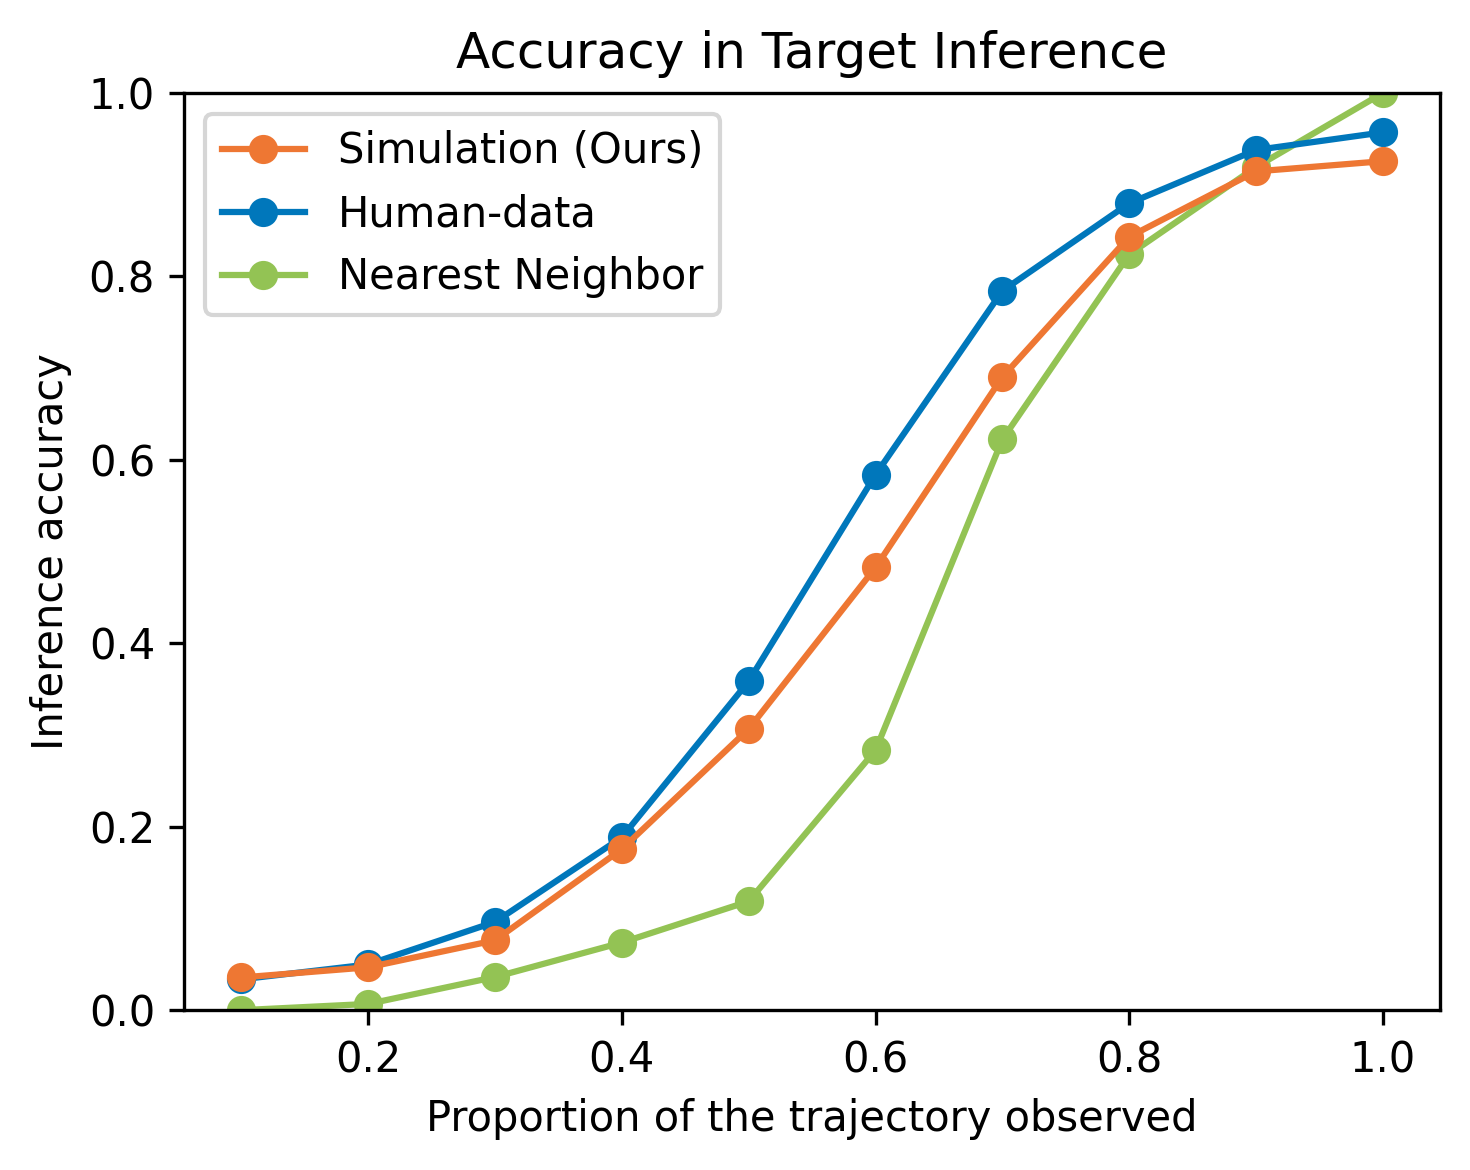

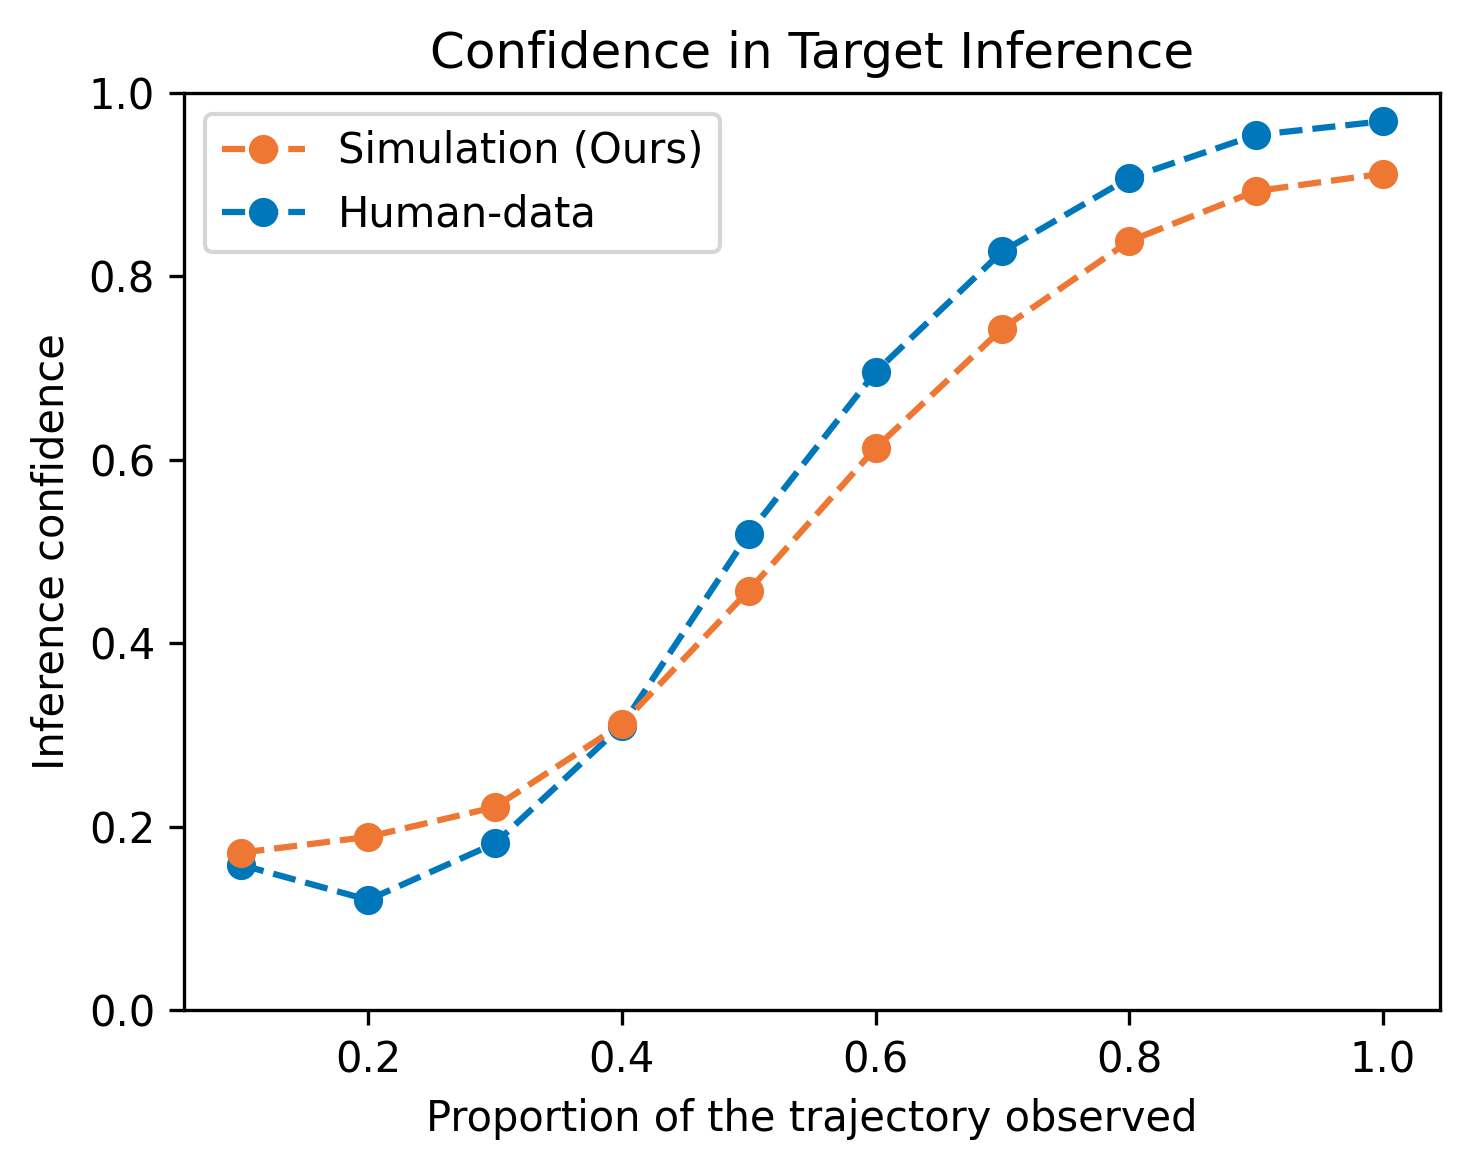

In [7]:
# Figure 13: Inference results per trajectory proportion

# Inference accuracy
fig = plt.figure(figsize=(5, 4), dpi=300)
x = np.arange(0.1, 1.1, 0.1)
y1 = np.array(acc_arr.mean(axis=1)[:, 0])
y2 = np.array(acc_arr.mean(axis=1)[:, 1])
y3 = np.array(acc_arr.mean(axis=1)[:, 2])

plt.plot(x, y1, marker="o", color="#93C354", label="Nearest Neighbor")
plt.plot(x, y2, marker="o", color="#0077BB", label="Human-data")
plt.plot(x, y3, marker="o", color="#EE7733", label="Simulation (Ours)")

#get handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

#specify order of items in legend
order = [2, 1, 0]

#add legend to plot
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])

plt.ylabel("Inference accuracy")
plt.xlabel("Proportion of the trajectory observed")
plt.ylim([0.0, 1.0])
plt.title("Accuracy in Target Inference")
plt.tight_layout()
plt.savefig(os.path.join("./results/plots", f"study3_inference_accuracy.pdf"), dpi=300)
plt.show()
plt.close(fig)

# Inference confidence
fig = plt.figure(figsize=(5, 4), dpi=300)
x = np.arange(0.1, 1.1, 0.1)
y1 = np.array(conf_arr.mean(axis=1)[:, 0])
y2 = np.array(conf_arr.mean(axis=1)[:, 1])

plt.plot(x, y1, marker="o", color="#0077BB", label="Human-data", linestyle="--")
plt.plot(x, y2, marker="o", color="#EE7733", label="Simulation (Ours)", linestyle="--")

#get handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

#specify order of items in legend
order = [1, 0]

#add legend to plot
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])

plt.ylabel("Inference confidence")
plt.xlabel("Proportion of the trajectory observed")
plt.ylim([0.0, 1.0])
plt.title("Confidence in Target Inference")
plt.tight_layout()
plt.savefig(os.path.join("./results/plots", f"study3_inference_confidence.pdf"), dpi=300)
plt.show()
plt.close(fig)